``lux.ai - Curso de Fotografia Computacional - Aprendizado de Máquina e Profundo``

## Restauração de imagens com UNet

```OBS: Quando pedido, realize a operação na célula correspondente atribuindo o resultado na variável indicada. Não altere os nomes das variáveis utilizadas. Você pode utilizar celular adicionais para realizar testes, utilizando variaveis auxiliares para visualizar resultados intermediários.```

Neste exemplo, vamos gerar um modelo que identifica e remove o ruído de uma imagem de entrada, como na imagem de exemplo abaixo:

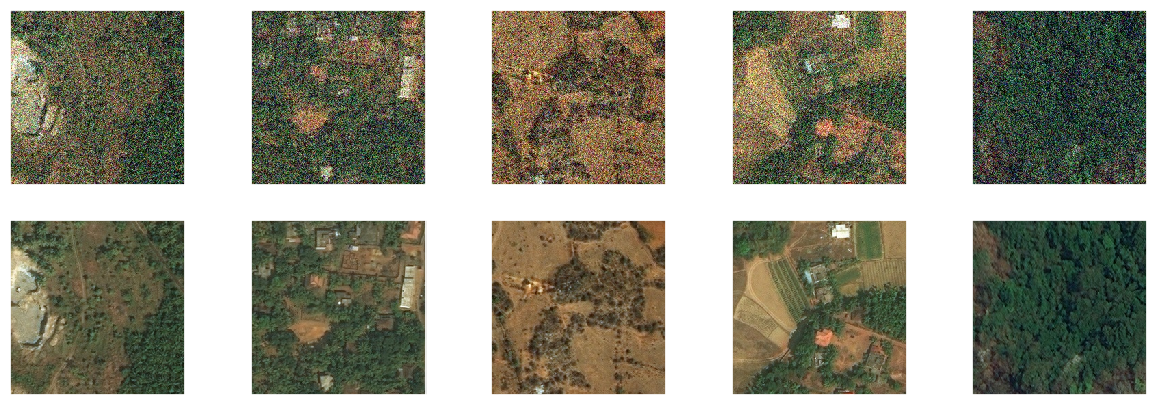

A imagem foi obtida do dataset [*Forest Aerial Images for Segmentation*](https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation?resource=download)

Ilke Demir, et al. DeepGlobe 2018: A Challenge to Parse the Earth Through Satellite Images, CVPRW 2018.

O dataset foi inicialmente proposto para segmentação, por isso vamos processa-lo e adicionar as informações necessárias para podermos treinar nosso modelo.

No diagrama abaixo temos o fluxo utilizado para gerar os exemplos e treinar os modelos:

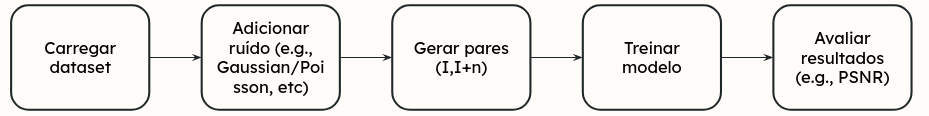

Primeiro, carregamos as imagens do dominio avaliado e adicionamos o ruído para que o modelo aprenda a identificar e remover a informação adicionada.

Nesse caso, a imagem original será a nossa label (target) e a imagem alterada será o exemplo passado para a rede.

Neste exemplo, vamos utilizar o [ruído gaussiano](https://pt.wikipedia.org/wiki/Ru%C3%ADdo_gaussiano).

O modelo que utilizaremos será a UNet, que deve receber as imagens com tamanho de entrada 256x256x3.
A especificação do modelo pode ser vista abaixo:

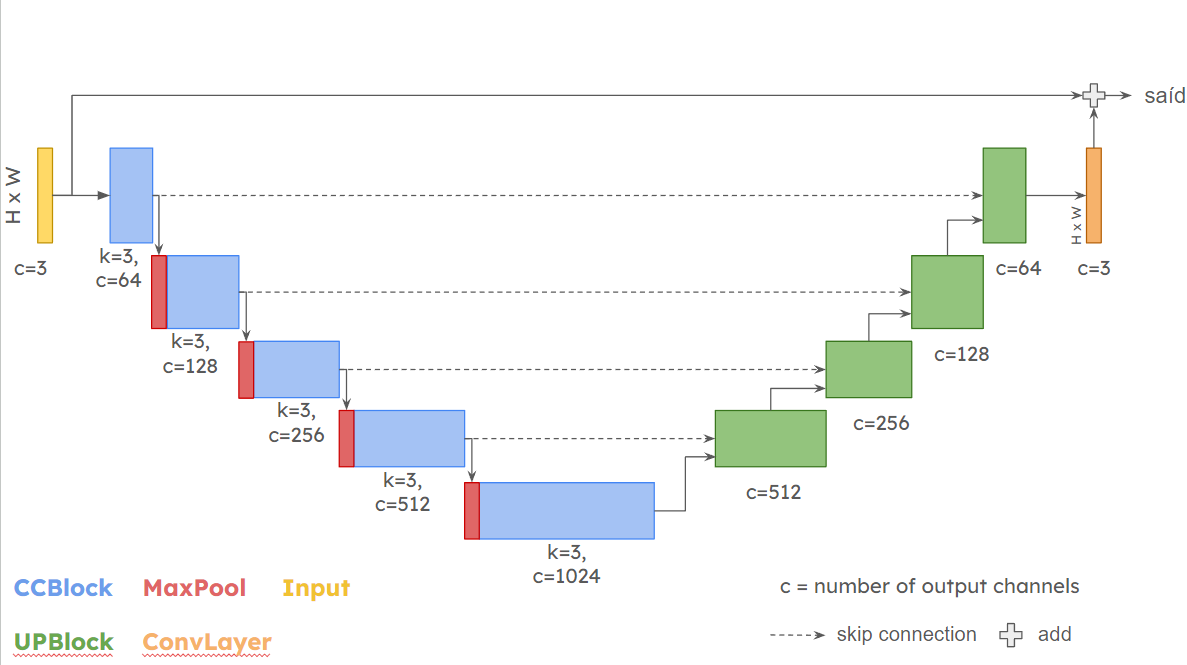

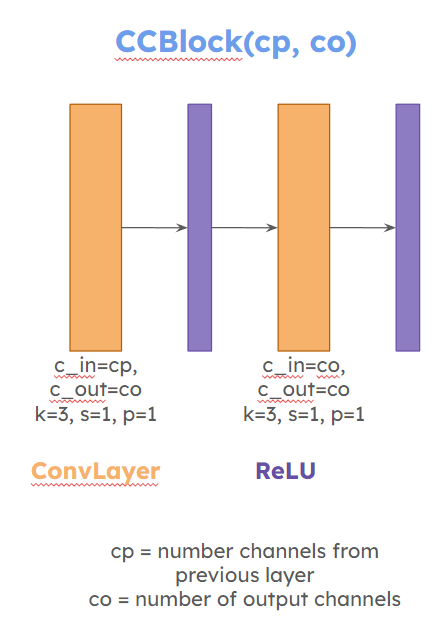

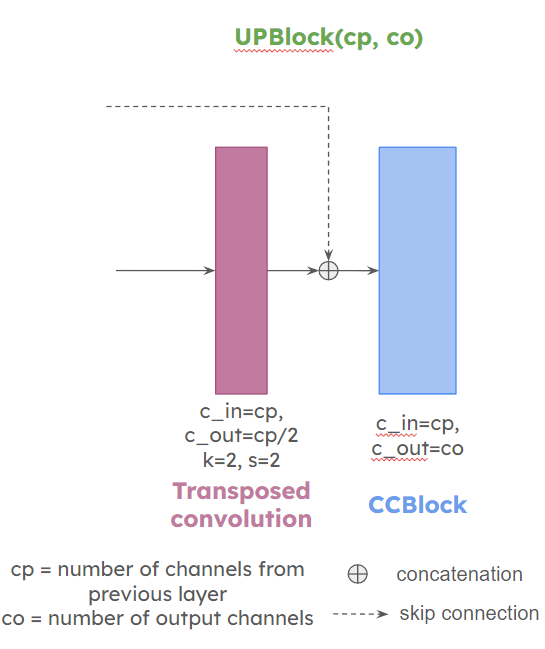

### 01 Importando bibliotecas e carregando o dataset

In [1]:
# modelagem e dados
import torch
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils import data

# avaliação de modelos
from sklearn.model_selection import train_test_split

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# operações de imagem
import cv2
from PIL import Image
import albumentations as A

# outros
import zipfile
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# fazer o download do dataset
!gdown 19nkkxpK8LN7fk9VPCdR1heatXhQKNWtO
!unzip kaggle_forest_segmentation.zip -d .

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/174980_mask_70.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/174980_mask_88.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_10.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_53.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_55.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_63.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/176225_mask_77.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/182422_mask_05.jpg  
  inflating: ./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/masks/182422_mask_07.jpg  
  inflating: .

In [3]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### 01 - Gerando o dataset

#### 01.1 Defina a função que adiciona ruído normal na imagem
- A função receberá a imagem (np) com pixels entre 0 e 1, e o valor sigma
- Adicione o ruído gaussiano ([np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)) com média 0 e variancia sigma/255 (lembre de checar se os valores ultrapassam o range 0-1, use o [np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html) para ajustar os valores)

In [4]:
def add_noise(image, sigma) -> np.array:
  noise = np.random.normal(0, sigma/255.0, image.shape)
  noisy_image = image + noise
  noisy_image = np.clip(noisy_image, 0, 1)

  return noisy_image

In [5]:
metadata_file = "./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/meta_data.csv"
metadata = pd.read_csv(metadata_file)
metadata.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [6]:
DIRECTORY = "./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/"
SIGMA     = 50

if not os.path.exists(os.path.join(DIRECTORY, "noisy")):
    os.mkdir(os.path.join(DIRECTORY, "noisy"))

noisy_imgs = []
for i in tqdm(range(len(metadata))):
    path = os.path.join(DIRECTORY, "images", metadata.iloc[i]["image"])
    img = cv2.imread(path)
    img = img.astype("float32") / 255
    noisy = add_noise(img, SIGMA)
    noisy = (noisy * 255).astype('uint8')
    noisy_path = os.path.join(DIRECTORY, "noisy", metadata.iloc[i]["image"].replace("sat", "noisy"))
    if cv2.imwrite(noisy_path, noisy):
        noisy_imgs.append(metadata.iloc[i]["image"].replace("sat", "noisy"))
    else:
        noisy_imgs.append(np.nan)

metadata["noisy"] = noisy_imgs

# Estrutura da pasta
"""
kaggle_forest_segmentation
  Forest Segmented/
    Forest Segmented/
      images/
      masks/
      noisy/
      meta_data.csv
"""

100%|██████████| 5108/5108 [01:07<00:00, 75.22it/s]


'\nkaggle_forest_segmentation\n  Forest Segmented/\n    Forest Segmented/\n      images/\n      masks/\n      noisy/\n      meta_data.csv\n'

In [7]:
metadata.head()

,image,mask,noisy
0,10452_sat_08.jpg,10452_mask_08.jpg,10452_noisy_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg,10452_noisy_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg,111335_noisy_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg,111335_noisy_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg,111335_noisy_02.jpg


In [8]:
train_val_paths, test_paths = train_test_split(metadata, test_size=0.2)
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.15)

In [9]:
# os exemplos estarão dividos e serão acessados atraves do dataframe carregado
train_paths.shape[0], val_paths.shape[0], test_paths.shape[0]

(3473, 613, 1022)

#### 01.2 Crie a classe de dataset que vamos utilizar para o treinamento
- defina as funções `__init__`, `__len__`, e `__getitem__`
- retorne a imagem original e a imagem com ruído
- Antes de retornar, transforme as imagens para torch.Tensor
- Lembre de ajustar as dimensões antes de retornar (torch=C,H,W, numpy/opencv=H,W,C)
- cheque o conteudo de train_paths, val_paths e test_paths, você deve ter acesso as imagens originais e com ruído a partir dessas variaveis (elas devem ser passadas no `__init__`)

In [10]:
class ForestImages(data.Dataset):

  def __init__(self, paths):
    self.paths = paths

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    img_path = os.path.join(DIRECTORY, "images", self.paths.iloc[index]["image"])
    noisy_img_path = os.path.join(DIRECTORY, "noisy", self.paths.iloc[index]["noisy"])

    img = cv2.imread(img_path)
    noisy_img = cv2.imread(noisy_img_path)

    img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32) / 255.0
    noisy_img = torch.tensor(noisy_img.transpose(2, 0, 1), dtype=torch.float32) / 255.0

    return img, noisy_img

In [11]:
print("train_paths:")
print(train_paths.head())

print("\nval_paths:")
print(val_paths.head())

print("\ntest_paths:")
print(test_paths.head())

train_paths:
                  image                mask                noisy
245    13415_sat_01.jpg   13415_mask_01.jpg   13415_noisy_01.jpg
538   162310_sat_18.jpg  162310_mask_18.jpg  162310_noisy_18.jpg
2873  644103_sat_05.jpg  644103_mask_05.jpg  644103_noisy_05.jpg
840   202277_sat_88.jpg  202277_mask_88.jpg  202277_noisy_88.jpg
4836  939614_sat_27.jpg  939614_mask_27.jpg  939614_noisy_27.jpg

val_paths:
                  image                mask                noisy
1415  299287_sat_15.jpg  299287_mask_15.jpg  299287_noisy_15.jpg
795   202277_sat_17.jpg  202277_mask_17.jpg  202277_noisy_17.jpg
4119  850510_sat_50.jpg  850510_mask_50.jpg  850510_noisy_50.jpg
3159  691384_sat_54.jpg  691384_mask_54.jpg  691384_noisy_54.jpg
401   148381_sat_74.jpg  148381_mask_74.jpg  148381_noisy_74.jpg

test_paths:
                  image                mask                noisy
3486  739760_sat_75.jpg  739760_mask_75.jpg  739760_noisy_75.jpg
3353   72807_sat_20.jpg   72807_mask_20.jpg   72807_

#### 01.3 Crie as variaveis do dataset de treino, validação e teste passando os respectivos caminhos e gere os dataloaders que serão usados no treino

In [12]:
train_ds = ForestImages(train_paths)
valid_ds = ForestImages(val_paths)
test_ds = ForestImages(test_paths)

train_dl = data.DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=32, shuffle=False)
test_dl = data.DataLoader(test_ds, batch_size=32, shuffle=False)

instances, targets = next(iter(train_dl))

print(instances.shape, targets.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


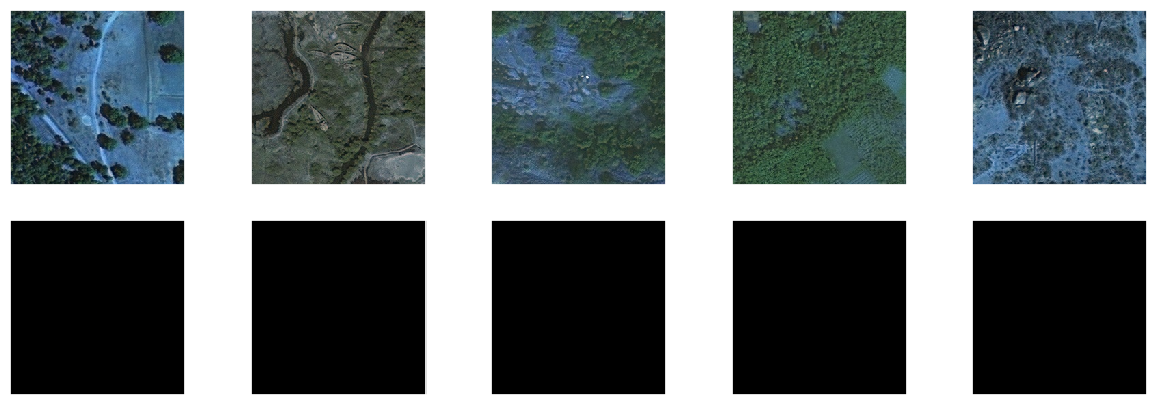

In [18]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))
for j in range(w):
    ax[0][j].imshow(instances[j].permute(1, 2, 0).numpy(), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow(targets[j].permute(1, 2, 0).numpy().astype("uint8"), interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

### 02 - Defina o modelo

#### 02.1 - Defina o bloco "CCBlock" como uma classe que herda de nn.Module (implemente o `__init__` e `forward`)
#### 02.2 - Defina o bloco "UpBlock"
- Voce pode utilizar o CCBlock internamente
- Trate no forward o uso da entrada e do skip connection
- Para juntar a entrada da camada com a entrada do skip use a função `torch.cat`

#### 02.3 - Construa o modelo utilizando as classes CCBlock e UpBlock
- Utilize outros módulos quando necessário (e.g., max pooling, convlayer)

#### 02.4 - Crie uma instancia para o modelo e passe para o device do ambiente
#### 02.5 - Imprima o modelo com o summary

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [20]:
class CCBlock(nn.Module):

  def __init__(self, in_channels, out_channels):
    super(CCBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.relu(out)
    return out

In [21]:
class UpBlock(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up_sampling = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv = CCBlock(in_channels, out_channels)

  def forward(self, x, skip):
    x = self.up_sampling(x)
    x = torch.cat([x, skip], dim=1)
    x = self.conv(x)
    return x

In [22]:
class Unet(nn.Module):

  def __init__(self, in_channels=3, out_channels=3):
    super().__init__()
    self.encoder_conv1 = CCBlock(in_channels, 64)
    self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder_conv2 = CCBlock(64, 128)
    self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder_conv3 = CCBlock(128, 256)
    self.encoder_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder_conv4 = CCBlock(256, 512)
    self.encoder_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.bottleneck_conv = CCBlock(512, 512)

    self.decoder_up4 = UpBlock(512 + 512, 256)
    self.decoder_up3 = UpBlock(256 + 256, 128)
    self.decoder_up2 = UpBlock(128 + 128, 64)
    self.decoder_up1 = UpBlock(64 + 64, 32)

    self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self, x):
    encoder1 = self.encoder_conv1(x)
    encoder1_pool = self.encoder_pool1(encoder1)
    encoder2 = self.encoder_conv2(encoder1_pool)
    encoder2_pool = self.encoder_pool2(encoder2)
    encoder3 = self.encoder_conv3(encoder2_pool)
    encoder3_pool = self.encoder_pool3(encoder3)
    encoder4 = self.encoder_conv4(encoder3_pool)
    encoder4_pool = self.encoder_pool4(encoder4)

    bottleneck = self.bottleneck_conv(encoder4_pool)

    decoder4 = self.decoder_up4(bottleneck, encoder4)
    decoder3 = self.decoder_up3(decoder4, encoder3)
    decoder2 = self.decoder_up2(decoder3, encoder2)
    decoder1 = self.decoder_up1(decoder2, encoder1)

    output = self.final_conv(decoder1)

    return output

In [23]:
summary(Unet().to(device), (3, 256, 256), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]           1,792
              ReLU-2          [1, 64, 256, 256]               0
            Conv2d-3          [1, 64, 256, 256]          36,928
              ReLU-4          [1, 64, 256, 256]               0
           CCBlock-5          [1, 64, 256, 256]               0
         MaxPool2d-6          [1, 64, 128, 128]               0
            Conv2d-7         [1, 128, 128, 128]          73,856
              ReLU-8         [1, 128, 128, 128]               0
            Conv2d-9         [1, 128, 128, 128]         147,584
             ReLU-10         [1, 128, 128, 128]               0
          CCBlock-11         [1, 128, 128, 128]               0
        MaxPool2d-12           [1, 128, 64, 64]               0
           Conv2d-13           [1, 256, 64, 64]         295,168
             ReLU-14           [1, 256,

In [39]:
model = Unet().to(device)

### Faça o treinamento

#### 03.1 Implemente o passo de treinamento
- Ative o modo de treino
- Faça o loop para iterar sob os batches
- Passe os exemplos e labels para o device do ambiente
- Realize os passos de treino (predição, loss, backpropagation)
- Retorne a média do loss

#### 03.2 Implemente o passo de validação
- Ative o modo de avaliação
- Desative os gradientes
- Faça o loop para iterar sob os batches
- Realize a avaliação (predição, loss)
- Retorne a média do loss

In [41]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
  model.train()

  epoch_loss = 0.0

  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  mean_loss = epoch_loss / len(loader)

  return mean_loss

def validation_step(model, loader, loss_fn, device) -> float:
  model.eval()

  epoch_loss = 0.0

  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, labels)

      epoch_loss += loss.item()

  mean_loss = epoch_loss / len(loader)

  return mean_loss

#### 03.4 Defina a função para executar o treino
- Defina o otimizador
- Defina a função de loss (use o loss L1)
- Defina o numero de epocas
- Itere sob as épocas executando o treinamento e validação em cada passo
- Salve (em lista) o loss de treino e validação em cada passo (imprima também o resultado em cada passo)
- Escolha o otimizador, o learning rate e o número de épocas para que o modelo aprenda corretamente (avalie os valores de loss de treino e validação para checar o resultado, e.g., overfitting ou underfitting)

In [42]:
train_losses = list()
valid_losses = list()

In [43]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=10):
  train_losses = []
  valid_losses = []

  for epoch in range(num_epochs):
    train_loss = train_step(model, train_loader, loss_fn, optimizer, device)
    train_losses.append(train_loss)

    valid_loss = validation_step(model, val_loader, loss_fn, device)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'.Train Loss: {train_loss:.4f}')
    print(f'.Validation Loss: {valid_loss:.4f}\n')

  return train_losses, valid_losses

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.L1Loss()

num_epochs = 10

train_losses, valid_losses = train_model(model, train_dl, valid_dl, optimizer, loss_fn, device, num_epochs)

Epoch 1/10:
.Train Loss: 0.4182
.Validation Loss: 0.1087

Epoch 2/10:
.Train Loss: 0.1063
.Validation Loss: 0.1051

Epoch 3/10:
.Train Loss: 0.1046
.Validation Loss: 0.1043

Epoch 4/10:
.Train Loss: 0.1039
.Validation Loss: 0.1039

Epoch 5/10:
.Train Loss: 0.1037
.Validation Loss: 0.1037

Epoch 6/10:
.Train Loss: 0.1035
.Validation Loss: 0.1036

Epoch 7/10:
.Train Loss: 0.1034
.Validation Loss: 0.1035

Epoch 8/10:
.Train Loss: 0.1034
.Validation Loss: 0.1035

Epoch 9/10:
.Train Loss: 0.1034
.Validation Loss: 0.1035

Epoch 10/10:
.Train Loss: 0.1034
.Validation Loss: 0.1035



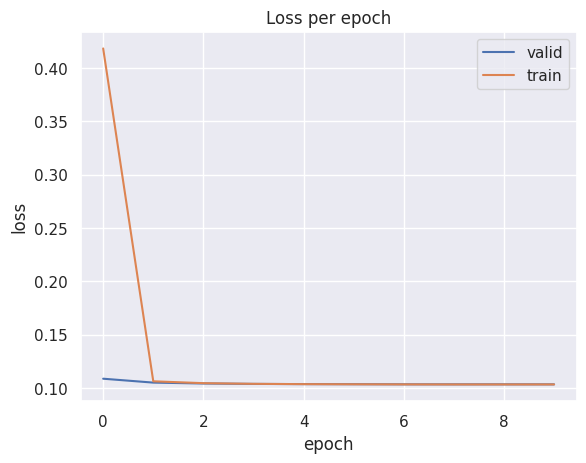

In [45]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch');
  plt.ylabel('loss');
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

### 03.5 Salve o modelo

In [46]:
model_path = 'model.pt'

torch.save(model.state_dict(), model_path)

print("Modelo treinado salvo em:", model_path)

Modelo treinado salvo em: model.pt


### 04 - Teste se o seu modelo está removendo ruídos corretamente

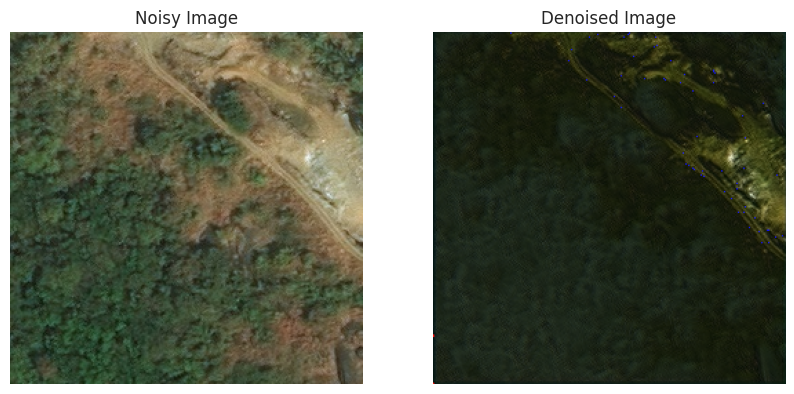

In [47]:
model = Unet()
model.load_state_dict(torch.load('model.pt'))
model.eval()

noisy_image_path = "./kaggle_forest_segmentation/Forest Segmented/Forest Segmented/images/111335_sat_00.jpg"
noisy_image = Image.open(noisy_image_path)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
noisy_image_tensor = transform(noisy_image).unsqueeze(0)

with torch.no_grad():
    denoised_image_tensor = model(noisy_image_tensor)

denoised_image = transforms.ToPILImage()(denoised_image_tensor.squeeze(0))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Noisy Image')
plt.imshow(noisy_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image)
plt.axis('off')
plt.show()